In [20]:
from os import sys
sys.path.append("/raid/MattC/repos/ProCogGraph/workflow/scripts")
import pandas as pd
from utils import Neo4jConnection

# Connect to ProCogGraph

In [21]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="yTJutYQ$$d%!9h")

The format for queries to the database is: 

```conn.query(query, db='neo4j', param=param)``` 

where query is a valid cypher query, in string format, either loaded from a yaml file or written directly as variable, and param is the name of a $ param in the query itself that will be passed.

# Promiscuous Ligand Analysis

In the original ProCognate paper, an analysis was performed of the superfamilies with the most different bound ligands. We will replicate this here:

## Result 1

In [54]:
query = """
MATCH (sf:scopSuperfamily)<-[:IS_IN_SCOP_SUPERFAMILY]-(sfa:scopFamily)<-[:IS_IN_SCOP_FAMILY]-(c:scopDomain {type : "SCOP"})-[int:INTERACTS_WITH_LIGAND]->(be:boundEntity)-[sim:HAS_SIMILARITY]->(bl:cognateLigand)
WHERE sim.parityScore >= toFloat($parity_score_cutoff) AND int.interactionMode in ["dominant", "unique"]
WITH sf.description AS scopSuperfamily, c.domain as scopDomain, be.entityName AS entityName, bl.uniqueID AS uniqueID, sim.parityScore AS parityScore
ORDER BY scopSuperfamily, scopDomain, entityName, parityScore, uniqueID DESC
WITH scopSuperfamily, COUNT(DISTINCT(uniqueID)) as num_uniqueids
ORDER BY num_uniqueids DESC
RETURN scopSuperfamily, num_uniqueids
LIMIT 40
"""

result = pd.DataFrame(conn.query(query = query, db='graph.db', parity_score_cutoff=0.55))

In [55]:
result

,0,1
0,NAD(P)-linked oxidoreductase,1294
1,P-loop containing nucleoside triphosphate hydr...,840
2,NAD(P)-binding Rossmann-fold domains,832
3,FMN-dependent nitroreductase-like,739
4,Nucleotide-diphospho-sugar transferases,611
5,(Trans)glycosidases,565
6,Acyl-CoA N-acyltransferases (Nat),556
7,Actin-like ATPase domain,485
8,alpha/beta-Hydrolases,461
9,Trimeric LpxA-like enzymes,428


# Domain interaction analysis

In ProCogGraph, domains are assigned ownership of a PDB ligand in 5 different possible ways: 
* Covalent
* Unique
* Dominant
* Partner
* Minor

on reflection, the percentages should be based on the total number of interacting domains - if three domains partner is some other cutoff ? 

In [3]:
cath_interactions = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240329/pdbe_graph_data/cath_pdb_residue_interactions.csv.gz")

/tmp/ipykernel_3423701/931952352.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  cath_interactions = pd.read_csv("/raid/MattC/repos/ProCogGraphData/procoggraph_20240329/pdbe_graph_data/cath_pdb_residue_interactions.csv.gz")


## Result 1

The vast majority of PDB ligands are bound covalently or in a unique or dominant manner (get numbers for this).

<Axes: xlabel='domain_ownership'>

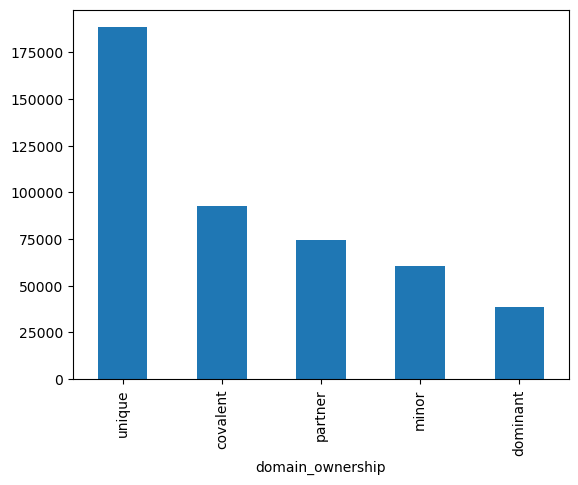

In [10]:
cath_interactions.domain_ownership.value_counts().plot(kind = "bar")

## Result 2

Domains may interact with more than one ligand, for example only having minor interactions to one ligand whilst having unique or dominant interactions to another ligand. What are the the things we can say from a domain perspective about these? Then, from a superfamily level - are there some superfamilies that only ever have minor interactions? e.g. they are passenger domains. And are some only ever having partner interactions - i.e. they need their partners to bind.

## Result 2

What are the types of PDB ligands that are bound in a partner interaction? What are their most likely cognate ligands.

In [16]:
cath_interactions.loc[cath_interactions.domain_ownership == "partner"].bound_ligand_name.value_counts().head(10)

bound_ligand_name
GOL    7265
SO4    6367
EDO    4439
CL     3232
ACT    1833
PO4    1663
DMS    1589
FAD    1409
MG     1098
ADP     913
Name: count, dtype: int64

## Result 3

Is there a correlation between molecule size and partner interaction i.e. as ligand size increases, the interactions move from unique to partner.

,pdb_id,pdb_descriptor,pdb_title,pdb_keywords,protein_entity_id,protein_entity_description,chainUniqueID,chain_id,auth_chain_id,ligand_entity_id,...,protein_entity_ec,ec_list,total_contact_counts,domain_contact_counts,domain_hbond_counts,domain_covalent_counts,domain_hbond_perc,domain_contact_perc,domain_ownership,ligand_uniqueID
0,151l,"LYSOZYME (E.C.3.2.1.17) MUTANT WITH THH 34, LY...",CONSERVATION OF SOLVENT-BINDING SITES IN 10 CR...,HYDROLASE(O-GLYCOSYL),151l_1,T4 LYSOZYME,151l_1_A,A,A,151l_2,...,3.2.1.17,3.2.1.17,4,4,3,0,0.750000,1.000000,unique,21223.0
1,170l,LYSOZYME (E.C.3.2.1.17) MUTANT WITH CYS 54 REP...,PROTEIN FLEXIBILITY AND ADAPTABILITY SEEN IN 2...,HYDROLASE (O-GLYCOSYL),170l_1,T4 LYSOZYME,170l_1_A,A,A,170l_2,...,3.2.1.17,3.2.1.17,1,1,0,0,0.000000,1.000000,unique,10932.0
2,160l,LYSOZYME (E.C.3.2.1.17) MUTANT WITH CYS 54 REP...,CONTROL OF ENZYME ACTIVITY BY AN ENGINEERED DI...,HYDROLASE(O-GLYCOSYL),160l_1,T4 LYSOZYME,160l_1_A,A,A,160l_2,...,3.2.1.17,3.2.1.17,1,1,0,0,0.000000,1.000000,unique,11722.0
3,160l,LYSOZYME (E.C.3.2.1.17) MUTANT WITH CYS 54 REP...,CONTROL OF ENZYME ACTIVITY BY AN ENGINEERED DI...,HYDROLASE(O-GLYCOSYL),160l_1,T4 LYSOZYME,160l_1_A,A,A,160l_3,...,3.2.1.17,3.2.1.17,2,2,0,0,0.000000,1.000000,unique,10932.0
4,160l,LYSOZYME (E.C.3.2.1.17) MUTANT WITH CYS 54 REP...,CONTROL OF ENZYME ACTIVITY BY AN ENGINEERED DI...,HYDROLASE(O-GLYCOSYL),160l_1,T4 LYSOZYME,160l_1_A,A,A,160l_3,...,3.2.1.17,3.2.1.17,5,5,1,0,0.200000,1.000000,unique,10932.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454481,8at1,ASPARTATE CARBAMOYLTRANSFERASE (ASPARTATE TRAN...,CRYSTAL STRUCTURES OF ASPARTATE CARBAMOYLTRANS...,"TRANSFERASE (CARBAMOYL-P,ASPARTATE)",8at1_1,"ASPARTATE CARBAMOYLTRANSFERASE (R STATE), CATA...",8at1_1_C,C,C,8at1_3,...,2.1.3.2,2.1.3.2,12,2,0,0,0.000000,0.166667,minor,280.0
454482,8cgt,NaN,STRUCTURE OF CYCLODEXTRIN GLYCOSYLTRANSFERASE ...,TRANSFERASE,8cgt_1,PROTEIN (CYCLODEXTRIN-GLYCOSYLTRANSFERASE),8cgt_1_A,A,A,8cgt_2,...,2.4.1.19,2.4.1.19,29,29,11,0,0.379310,1.000000,unique,1171.0
454483,8pch,CATHEPSIN H,CRYSTAL STRUCTURE OF PORCINE CATHEPSIN H DETER...,HYDROLASE,8pch_1,CATHEPSIN H,8pch_1_A,A,A,8pch_3,...,3.4.22.16,3.4.22.16,22,22,1,1,0.045455,1.000000,covalent,741.0
454484,9cgt,NaN,STRUCTURE OF CYCLODEXTRIN GLYCOSYLTRANSFERASE ...,TRANSFERASE,9cgt_1,PROTEIN (CYCLODEXTRIN-GLYCOSYLTRANSFERASE),9cgt_1_A,A,A,9cgt_2,...,2.4.1.19,2.4.1.19,27,27,10,0,0.370370,1.000000,unique,1172.0
